# Predicting Airline Passenger Numbers with LSTM Neural Networks

This project utilizes Long Short-Term Memory (LSTM) neural networks to forecast future airline passenger numbers based on historical data, demonstrating data preprocessing, model training, and evaluation techniques in Python.

## What's Included in This Project

- Data loading and visualization of international airline passenger numbers.
- Data preprocessing steps including scaling and transformation for neural network compatibility.
- Implementation of an LSTM model for time series forecasting.
- Model training with specified hyperparameters and online training technique.
- Predictions on both training and test datasets to evaluate model performance.
- Inverse transformation of predictions and actual values for meaningful evaluation.
- Calculation and presentation of model accuracy using Root Mean Squared Error (RMSE).

## Package Requirements

In [2]:
# Data manipulation and numerical operations
import numpy as np
import pandas as pd
import math

# Machine learning and neural network libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Visualization library
import matplotlib.pyplot as plt

# Standard library imports
%matplotlib inline

## Load and Visualize Data

In [3]:
# Load dataset from a CSV file
dataset = pd.read_csv(
    "../data/raw/international_airline_passengers.csv",
    usecols=[1],  # Column index to use (Python indices start from 0)
    engine="python",  # Parser engine to use. 'python' allows for more options like skipfooter
    skipfooter=3,  # Number of rows at the bottom of the file to skip
)

# Display the first few rows of the dataset to verify its structure and content
dataset.head()

,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,112
1,118
2,132
3,129
4,121


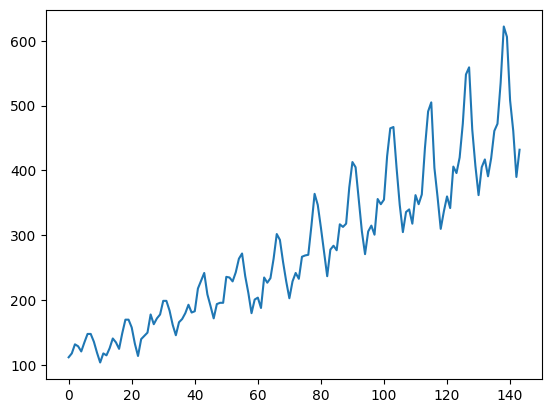

In [4]:
# Create a line plot
plt.plot(dataset)

# Display the plot
plt.show()

## Data Preparation

In [5]:
# Initialize the random number generator with a fixed seed for reproducibility
np.random.seed(7)

In [6]:
# Convert the DataFrame to a NumPy array
dataset = dataset.values

# Cast the dataset to float32 for consistent data type and efficient computation
dataset = dataset.astype("float32")

In [7]:
# Initialize a MinMaxScaler to scale the dataset values to a range of 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler to the dataset and transform the data to scale it within the specified range
dataset = scaler.fit_transform(dataset)

# Display the scaled dataset
dataset

array([[0.01544401],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984557],
       [0.08494207],
       [0.08494207],
       [0.06177607],
       [0.02895753],
       [0.        ],
       [0.02702703],
       [0.02123553],
       [0.04247104],
       [0.07142857],
       [0.05984557],
       [0.04054055],
       [0.08687258],
       [0.12741312],
       [0.12741312],
       [0.10424709],
       [0.05598456],
       [0.01930502],
       [0.06949806],
       [0.07915059],
       [0.08880308],
       [0.14285713],
       [0.11389962],
       [0.13127413],
       [0.14285713],
       [0.18339768],
       [0.18339768],
       [0.15444016],
       [0.11196911],
       [0.08108109],
       [0.1196911 ],
       [0.12934363],
       [0.14671814],
       [0.17181468],
       [0.14864865],
       [0.15250966],
       [0.22007722],
       [0.24324325],
       [0.26640925],
       [0.2027027 ],
       [0.16795367],
       [0.13127413],
       [0.173

In [8]:
# Calculate the train size as 67% of the total dataset length
train_size = int(len(dataset) * 0.67)

# Calculate the test size by subtracting the train size from the total dataset length
test_size = len(dataset) - train_size

# Split the dataset into training and testing sets based on the calculated train_size
train, test = dataset[0:train_size, :], dataset[train_size : len(dataset), :]

# Print the lengths of the training and testing datasets
print(f"Train set: {len(train)}")
print(f"Test set: {len(test)}")

Train set: 96
Test set: 48


In [9]:
# Define a function to transform the dataset into a format suitable for time series forecasting
def create_dataset(dataset, look_back=1):
    # Initialize empty lists to hold the input (X) and output (Y) sequences
    dataX, dataY = [], []

    # Iterate over the dataset with the specified look back
    for i in range(len(dataset) - look_back - 1):
        # Create the input sequence based on the look_back period
        a = dataset[i : (i + look_back), 0]

        # Append the input sequence to the dataX list
        dataX.append(a)

        # Append the next value in the sequence to the dataY list as the output
        dataY.append(dataset[i + look_back, 0])

    # Convert the lists into NumPy arrays and return them
    return np.array(dataX), np.array(dataY)

In [10]:
# Set the number of previous time steps to look back for creating the input data sequences
look_back = 3

# Create training and testing datasets using the defined look_back value
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [11]:
# Reshape the training and testing input data into a format [samples, time steps, features] which is the expected input format for LSTMs
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Print the reshaped training and testing datasets
print(f"Train set: {trainX}")
print(f"Test set: {testX}")

Train set: [[[0.01544401 0.02702703 0.05405405]]

 [[0.02702703 0.05405405 0.04826255]]

 [[0.05405405 0.04826255 0.03281853]]

 [[0.04826255 0.03281853 0.05984557]]

 [[0.03281853 0.05984557 0.08494207]]

 [[0.05984557 0.08494207 0.08494207]]

 [[0.08494207 0.08494207 0.06177607]]

 [[0.08494207 0.06177607 0.02895753]]

 [[0.06177607 0.02895753 0.        ]]

 [[0.02895753 0.         0.02702703]]

 [[0.         0.02702703 0.02123553]]

 [[0.02702703 0.02123553 0.04247104]]

 [[0.02123553 0.04247104 0.07142857]]

 [[0.04247104 0.07142857 0.05984557]]

 [[0.07142857 0.05984557 0.04054055]]

 [[0.05984557 0.04054055 0.08687258]]

 [[0.04054055 0.08687258 0.12741312]]

 [[0.08687258 0.12741312 0.12741312]]

 [[0.12741312 0.12741312 0.10424709]]

 [[0.12741312 0.10424709 0.05598456]]

 [[0.10424709 0.05598456 0.01930502]]

 [[0.05598456 0.01930502 0.06949806]]

 [[0.01930502 0.06949806 0.07915059]]

 [[0.06949806 0.07915059 0.08880308]]

 [[0.07915059 0.08880308 0.14285713]]

 [[0.08880308 

## Model Training

In [12]:
# Initialize the Sequential model
model = Sequential()

# Add an LSTM layer with 4 units (neurons). The input shape is specified as (1, look_back),
# corresponding to the time steps and features of the input data
model.add(LSTM(4, input_shape=(1, look_back)))

# Add a Dense layer with 1 unit (neuron) for the output layer to predict the future value
model.add(Dense(1))

# Compile the model using the mean squared error as the loss function and Adam optimizer
model.compile(loss="mean_squared_error", optimizer="adam")

# Train the model on the training dataset
# The batch size is set to 1 for online training, and
# verbosity level 2 is used for a more concise training log output
model.fit(trainX, trainY, batch_size=1, verbose=2)




92/92 - 2s - loss: 0.0355 - 2s/epoch - 18ms/step


## Model Prediction and Evaluation

In [13]:
# Use the trained model to make predictions on the training dataset
trainPredict = model.predict(trainX)

# Use the trained model to make predictions on the testing dataset
testPredict = model.predict(testX)

# Print the predictions for both the training and testing sets
print(f"Prediction on train set: {trainPredict}")
print(f"Prediction on test set: {testPredict}")

2/2 [==============================] - 0s 3ms/step
Prediction on train set: [[0.09742266]
 [0.10131101]
 [0.10216913]
 [0.1003283 ]
 [0.1028021 ]
 [0.10751583]
 [0.1088582 ]
 [0.10570342]
 [0.09993815]
 [0.0947487 ]
 [0.09607255]
 [0.0973461 ]
 [0.09983441]
 [0.10449024]
 [0.10476302]
 [0.10235232]
 [0.10695681]
 [0.11472391]
 [0.11713269]
 [0.11379085]
 [0.10616244]
 [0.09937146]
 [0.10300183]
 [0.10753234]
 [0.10996062]
 [0.11643189]
 [0.1170699 ]
 [0.11717666]
 [0.12016308]
 [0.1254288 ]
 [0.12780303]
 [0.12403706]
 [0.11689422]
 [0.11105601]
 [0.11348019]
 [0.1174047 ]
 [0.1203212 ]
 [0.12397733]
 [0.12321913]
 [0.12285775]
 [0.1307126 ]
 [0.1379798 ]
 [0.14116183]
 [0.13575456]
 [0.12712519]
 [0.12133593]
 [0.12351521]
 [0.126836  ]
 [0.12799275]
 [0.13618423]
 [0.1410609 ]
 [0.14005762]
 [0.14237413]
 [0.14834034]
 [0.1518459 ]
 [0.14572282]
 [0.1351436 ]
 [0.12594375]
 [0.12622708]
 [0.12920861]
 [0.12741578]
 [0.13480218]
 [0.13947672]
 [0.14035007]
 [0.1475325 ]
 [0.15822044]


In [14]:
# Inverse transform the predictions for the training set back to their original scale
trainPredict = scaler.inverse_transform(trainPredict)

# Inverse transform the predictions for the testing set back to their original scale
testPredict = scaler.inverse_transform(testPredict)

# Inverse transform the actual values for the training set back to their original scale
# The transformation expects the input to be a 2D array, hence the use of [trainY]
trainY = scaler.inverse_transform([trainY])

# Inverse transform the actual values for the testing set back to their original scale
testY = scaler.inverse_transform([testY])

# Print the inverse-transformed actual values for both the training and testing sets
print(f"Inverse-transformed train set: {trainY} ")
print(f"Inverse-transformed  test set: {testY}")

Inverse-transformed train set: [[129.00000163 120.99999632 135.00000368 147.99999397 147.99999397
  136.00000531 119.00000078 103.99999952 117.99999916 115.00000199
  125.99999674 140.99999801 135.00000368 125.00000283 148.9999956
  169.99999891 169.99999891 157.99999481 133.00000042 114.00000036
  139.99999638 145.00000452 149.99999723 177.9999965  163.00000295
  172.00000217 177.9999965  198.99999982 198.99999982 184.00000627
  162.00000133 146.00000615 165.9999924  171.00000054 179.99999976
  193.00000549 181.00000139 183.00000464 217.99999988 230.00000398
  241.99999264 209.00000066 191.00000223 172.00000217 194.00000712
  195.99999493 195.99999493 235.99999831 234.99999668 229.00000235
  242.99999427 263.99999759 272.00001061 236.99999994 211.00000392
  179.99999976 201.00000308 203.99999252 187.99999735 234.99999668
  226.9999991  233.99999506 263.99999759 301.99999771 292.99999849
  259.00000488 229.00000235 203.00000633 229.00000235 241.99999264
  232.99999343 266.99998703 268.

In [15]:
# Calculate the Root Mean Squared Error (RMSE) for the training dataset predictions
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print("Train Score: %.2f RMSE" % (trainScore))

# Calculate the Root Mean Squared Error (RMSE) for the testing dataset predictions
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print("Test Score: %.2f RMSE" % (testScore))

Train Score: 74.36 RMSE
Test Score: 229.38 RMSE


## Learnings (Q&A)


1. **What is the purpose of using LSTM (Long Short-Term Memory) networks in time series forecasting, and how do they differ from traditional neural networks?**

    LSTMs are used for sequential data like airline passenger numbers. They remember patterns over time, unlike traditional neural networks. In this notebook, we used an LSTM to look at 3 previous months of data to predict the next month's value. Traditional neural networks can't maintain information about previous time steps, making them less effective for time series data.

2. **Explain the importance of data preprocessing steps such as scaling (using MinMaxScaler) and reshaping the input data for LSTM models. How does each step contribute to model performance?**

    - **Scaling with MinMaxScaler:** We scaled passenger numbers to values between 0 and 1, helping the LSTM learn more efficiently. Without scaling, the model might prioritize larger values over smaller ones due to their magnitude.
    - **Reshaping:** We reshaped our data into a 3D format [samples, time steps, features], required by LSTM layers. This structure helps the LSTM process temporal relationships in our data.

    Both steps improve the model's ability to learn patterns and make accurate predictions.

3. **Describe the process of splitting a dataset into training and testing sets for a machine learning project. Why is this step crucial for evaluating the model's generalization capability?**

    We split the data with 67% (96 months) for training and 33% (48 months) for testing, using earlier time periods for training and later periods for testing. This split helps us evaluate how well our model can predict new, unseen data. The test set simulates the real-world scenario where we want to predict future passenger numbers based on historical data.

4. **How is the Root Mean Squared Error (RMSE) used to evaluate the performance of a machine learning model in time series forecasting, and what does a lower RMSE value indicate about the model's predictions?**

    RMSE measures the difference between predicted and actual values. A lower RMSE indicates more accurate predictions. Our model performed better on the training data than on the test data, suggesting some overfitting. The goal is to minimize RMSE, especially on the test set, to ensure reliable predictions.

5. **Discuss the significance of setting a random seed (e.g., np.random.seed(7)) in the context of machine learning experiments. How does this practice affect the reproducibility of model results?**

    Setting a random seed ensures reproducible results by fixing the random weight initializations in our LSTM model. This allows anyone following the notebook to get identical results, making comparisons between different model iterations meaningful and aiding in debugging and troubleshooting.
